In [1]:
import os
import re
import pathlib
import time
import itertools
import glob
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython import display
from sklearn.model_selection import train_test_split

## Loading dataset

In [2]:
zoom = 15
shadow_path = 'e://Dropbox/vgc//shadow-slippy-vis//www//assets//nyc-dec-21//'
ortho_path = 'data/nyc-ortho/'
height_path = 'data/nyc-heights/'

In [156]:
def load(zoom, i, j):
    
    ortho_image = tf.io.read_file(ortho_path+'/%d/%d/%d.jpg'%(zoom,i,j))
    ortho_image = tf.io.decode_png(ortho_image)[:,:,]
    ortho_image = ortho_image.numpy()
    
    height_image = tf.io.read_file(height_path+'/%d/%d/%d.png'%(zoom,i,j))
    height_image = tf.io.decode_png(height_image)[:,:,]
    height_image = height_image.numpy()
#     ortho_image[height_image[:,:,0]>0] = 0
    input_image = ortho_image
    input_image = input_image[:,:,:3]
    
    real_image = tf.io.read_file(shadow_path+'/%d/%d/%d.png'%(zoom,i,j))
    real_image = tf.io.decode_png(real_image)[:,:,0]
    real_image = real_image.numpy()
    real_image[height_image[:,:,0]>0] = 0
    
    input_image = tf.convert_to_tensor(input_image)
#     input_image = tf.reshape(input_image, (*input_image.shape, 1))
#     input_image = tf.image.grayscale_to_rgb(input_image)
    
    real_image = tf.convert_to_tensor(real_image)
    real_image = tf.reshape(real_image, (*real_image.shape, 1))
    real_image = tf.image.grayscale_to_rgb(real_image)
    
    
    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    
    return input_image, real_image

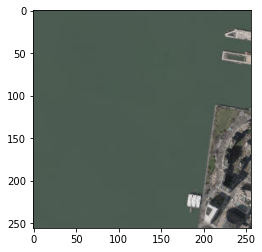

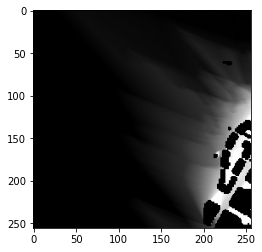

In [157]:
inp, real = load(zoom, 9646, 12319) # 9646, 12319 # 9652, 12316 # 9655, 12306
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(real / 255.0)

In [110]:
# The facade training set consist of 400 images
BUFFER_SIZE = 200
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [111]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

#     if tf.random.uniform(()) > 0.5:
        # Random mirroring
#         input_image = tf.image.flip_left_right(input_image)
#         real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

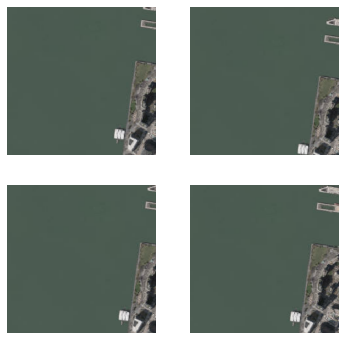

In [112]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, real)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [113]:
def load_image_train(image_path):
    tks = re.findall(r'\d+', image_path)
    zoom, i, j = int(tks[-3]), int(tks[-2]), int(tks[-1])
    
    input_image, real_image = load(zoom, i, j)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    input_image = tf.reshape(input_image, (1, *input_image.shape))
    real_image = tf.reshape(real_image, (1, *real_image.shape))
    
    return input_image, real_image

def load_image_test(image_path):
    tks = re.findall(r'\d+', image_path)
    zoom, i, j = int(tks[-3]), int(tks[-2]), int(tks[-1])
    
    input_image, real_image = load(zoom, i, j)
    input_image, real_image = resize(input_image, real_image,IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    
    input_image = tf.reshape(input_image, (1, *input_image.shape))
    real_image = tf.reshape(real_image, (1, *real_image.shape))

    return input_image, real_image

## Input pipeline

In [114]:
all_dataset = glob.glob(ortho_path+'/%d/*/*.jpg'%(zoom))

In [115]:
train_dataset, test_dataset = train_test_split(all_dataset, train_size=BUFFER_SIZE, random_state=42)

## Build generator

In [116]:
OUTPUT_CHANNELS = 3

# encoder
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

# decoder
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [117]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)
(1, 256, 256, 3)


In [118]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

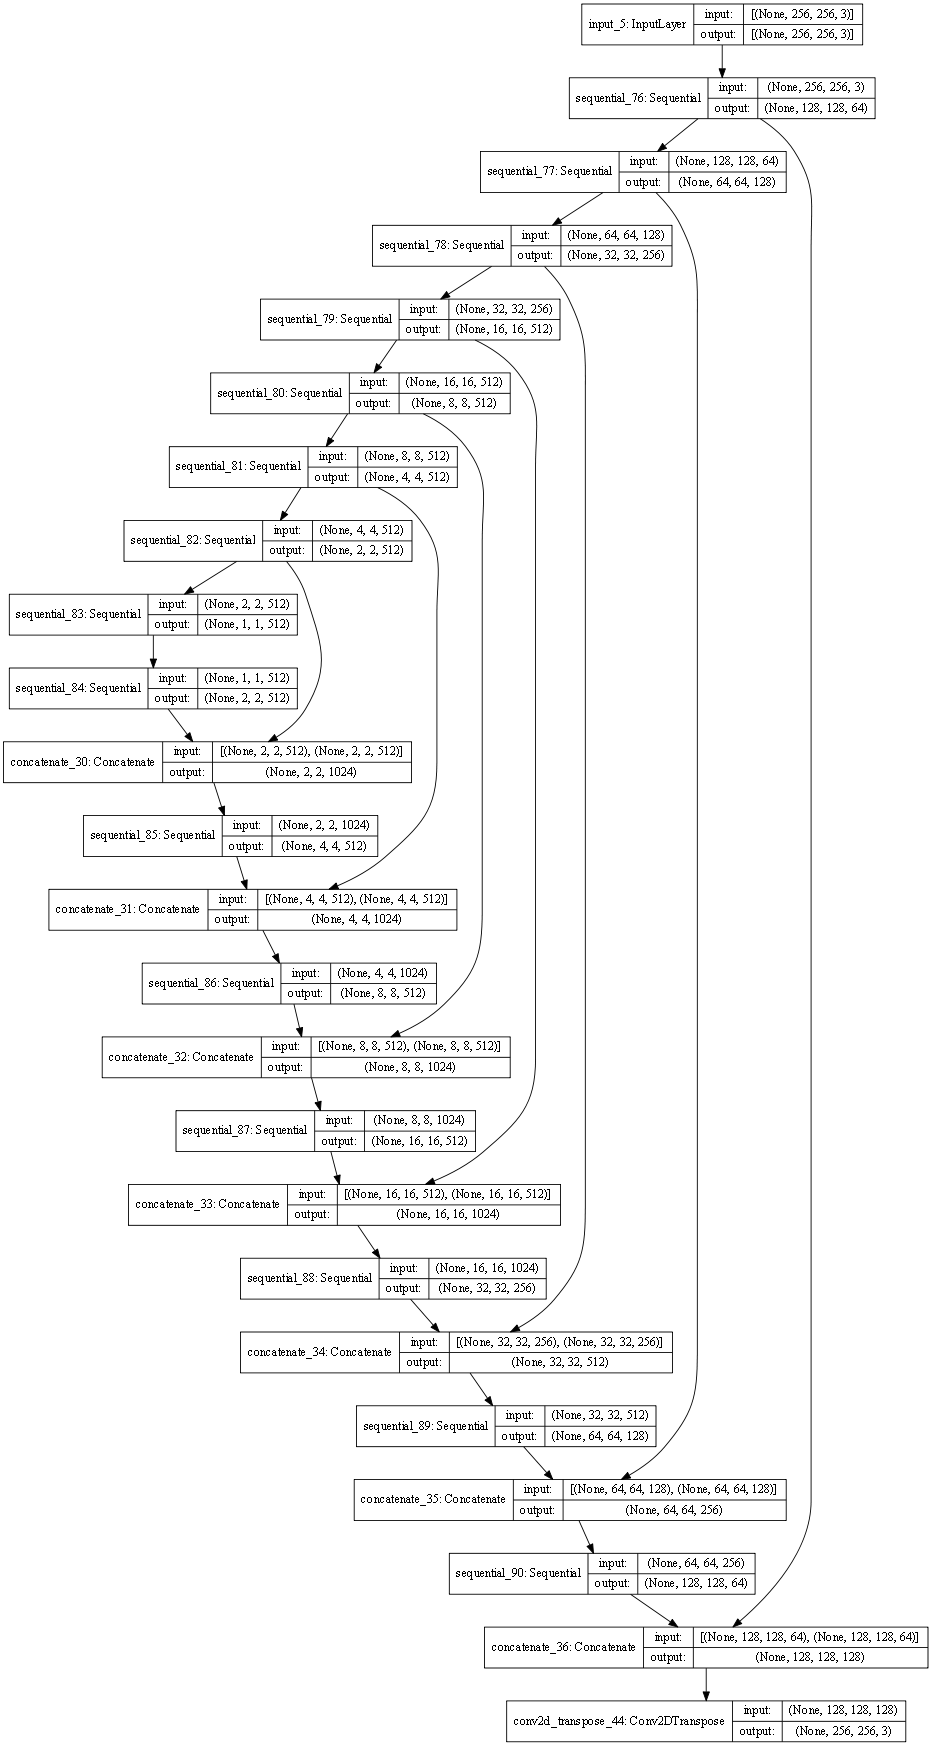

In [119]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


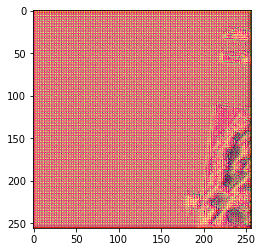

In [120]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Generator loss

In [121]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Build discriminator

In [122]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


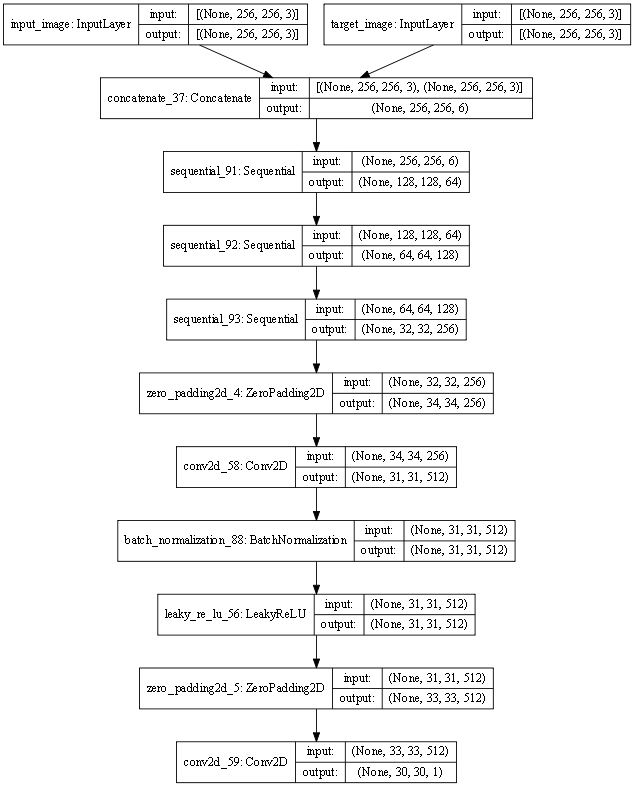

In [123]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

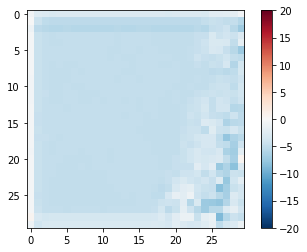

In [124]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## Discriminator loss

In [125]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

## Optimizers and a checkpoint-saver

In [126]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [127]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

In [140]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    print(test_input[0].shape, tar[0].shape, prediction[0].shape)

    plt.subplot(1, 3, 1)
    plt.title(title[0])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow((display_list[0] * 0.5 + 0.5))
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(title[1])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow((display_list[1] * 0.5 + 0.5))
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title(title[2])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[2] * 0.5 + 0.5)
    plt.axis('off')
    
    plt.show()

In [164]:
sample = np.random.choice(test_dataset,1)

(256, 256, 3) (256, 256, 3) (256, 256, 3)


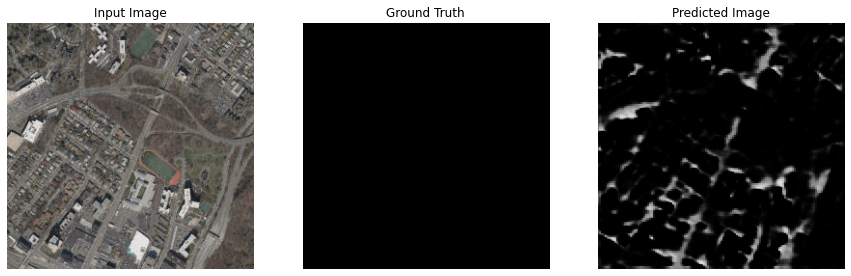

In [167]:
for filename in sample:
    example_input, example_target = load_image_test(filename)
    generate_images(generator, example_input, example_target)

## Training

In [136]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [137]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [138]:
def fit(train_ds, test_ds, steps):
    filename = np.random.choice(test_ds)
    example_input, example_target = load_image_test(filename)
    start = time.time()

    step = 0
    for filename in np.random.choice(train_ds,steps):
        input_image, target = load_image_test(filename)
        
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        step+=1

In [50]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 26572), started 5 days, 6:26:20 ago. (Use '!kill 26572' to kill it.)

Time taken for 1000 steps: 2174.70 sec

(256, 256, 3) (256, 256, 3) (256, 256, 3)


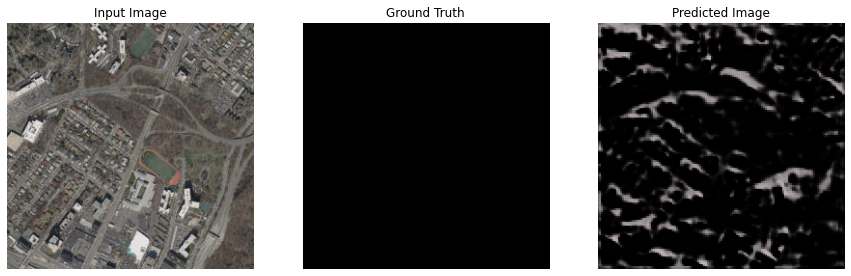

Step: 1k
...................

KeyboardInterrupt: 

In [166]:
fit(train_dataset, test_dataset, steps=40000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


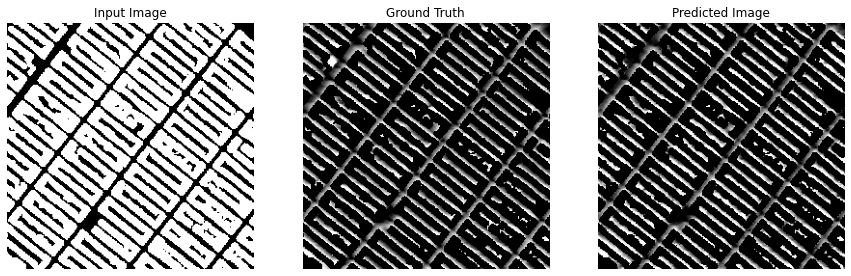

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


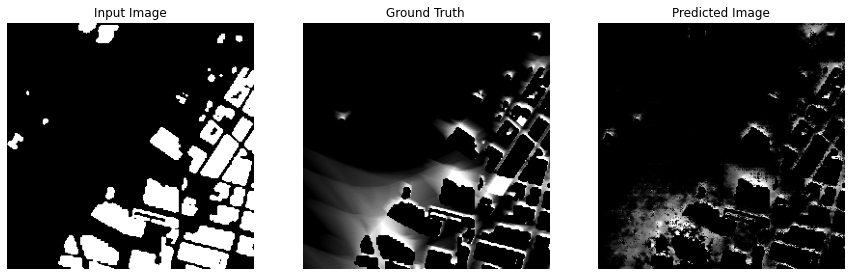

(1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


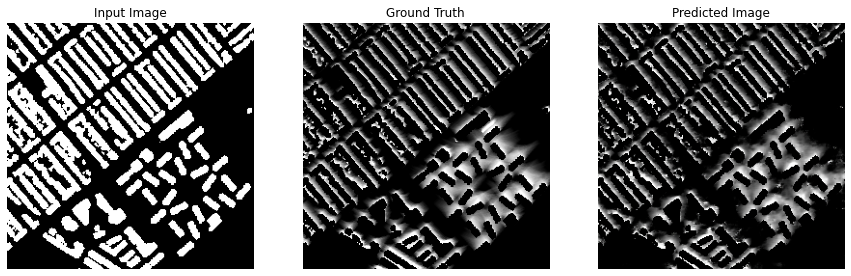

(1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


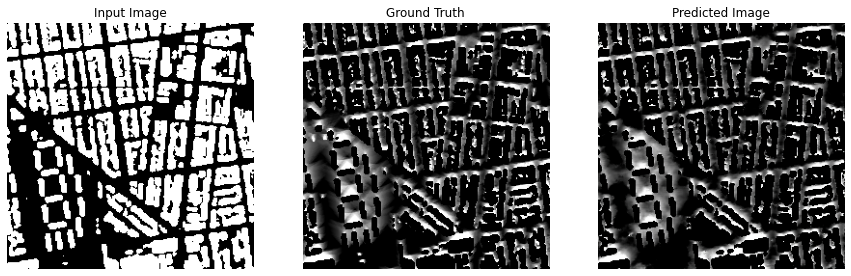

(1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


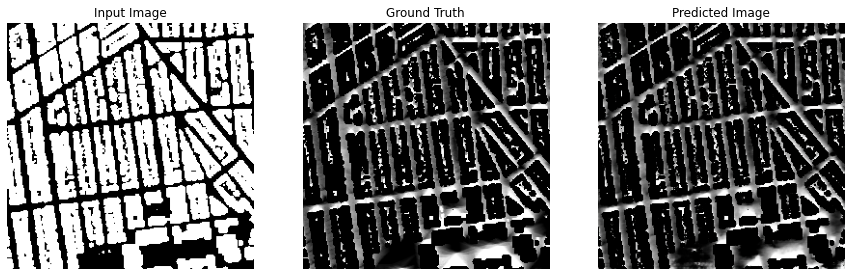

In [568]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
for filename in np.random.choice(test_dataset,5):
    inp, tar = load_image_test(filename)
    generate_images(generator, inp, tar)

In [601]:
rmses = []
for filename in test_dataset:
    test_input, test_target = load_image_test(filename)
    prediction = generator(test_input, training=True)
    
    test_input = test_input.numpy()
    test_target = test_target.numpy()
    prediction = prediction.numpy()
    
    test_input = test_input * 0.5 + 0.5
    test_target = test_target * 0.5 + 0.5
    prediction = prediction * 0.5 + 0.5
    
    rmse = np.sqrt(np.mean((prediction-test_target)**2))
    rmses.append(rmse)
    
#     plt.figure(figsize=(15, 15))
#     plt.subplot(1, 2, 1)
#     plt.title('Target')
#     plt.imshow(test_target[0,:,:,:])
#     plt.axis('off')
    
#     plt.subplot(1, 2, 2)
#     plt.title('Prediction')
#     plt.imshow(prediction[0,:,:,:])
#     plt.axis('off')
    
#     plt.show()

In [602]:
np.average(rmses)

0.11841513